# ResNet Ablation

## 실습목표

* 직접 ResNet 구현하기
* 모델을 config에 따라서 변경 가능하도록 만들기
* 직접 실험해서 성능 비교하기

## 학습내용

1. Ablation Study
2. CIFAR-10 데이터셋 준비
3. 블록 구성
4. VGG Complete Model
5. VGG-16 vs VGG-19
6. ResNet Ablation Study

## Ablation Study

* Ablation Study : 제거 연구
* 딥러닝에서 해당 방법을 제거한 모델과 제거하지 않은 모델의 결과를 비교하는 연구
* ResNet이 residual connection의 애블레이션 연구

## CIFAR-10 dataset 준비하기

### CIFAR-10

* Dataset 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

* GPU 장착 확인

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

2022-10-17 17:08:59.730909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 17:08:59.801584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 17:08:59.801765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

* tfds.load() : default로 ~/tensorflow_datasets 경로에 데이터셋을 다운로드
* data_dir : 데이터셋 경로 변경

In [3]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir = 'data'
)

2022-10-17 17:08:59.898618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 17:08:59.900709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 17:08:59.901022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 17:08:59.901151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

* feature 정보 확인

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### Input Normalization

* Data Normalization : 데이터의 범위를 사용자가 원하는대로 제한하는 것
* 최댓값인 255로 정규화(normalize) 해주어 이미지 표현이 0과 1 사이로 들어오도록 해줌

In [6]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

* label 확인

In [8]:
ds_info.features["label"].num_classes

10

In [9]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

2022-10-17 17:09:01.247812: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


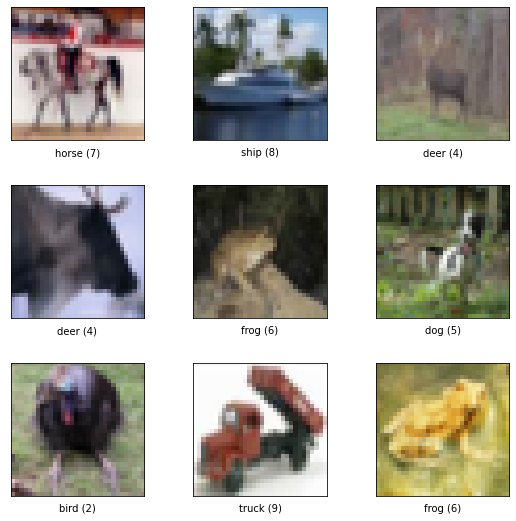

In [10]:
fig = tfds.show_examples(ds_train, ds_info)

2022-10-17 17:09:01.545713: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


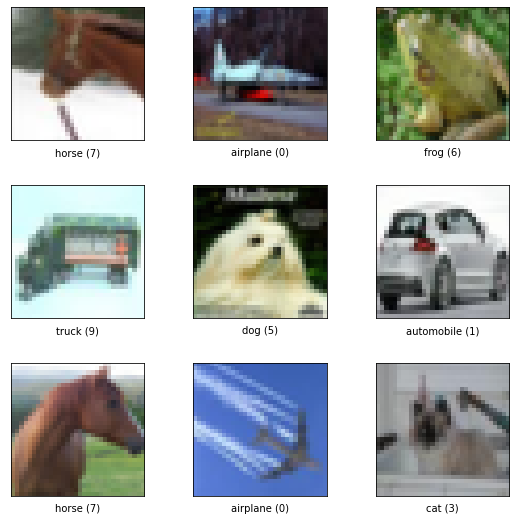

In [11]:
fig = tfds.show_examples(ds_test, ds_info)

## 블록 구성하기

### ResNet 구조

* 블록(Block) : 주요 구조를 모듈화하여 조금씩 바꾸어 쓸 수 있는 단위
* 레이어(Layer) : Tensroflow, Keras, Pytorch 등에서 기본적으로 제공하는 단위

<img src = 'image/Architecture1.png' height = 70% width = 70%>

(from Deep Residual Learning for Image Recognition Paper)

* ResNet을 보면 ResNet-18, 34, 50, 101, 152로 다섯가지 네트워크가 있습니다.
* 일일히 따로 만들기는 불편하기에 기본 구조인 블록부터 구현하겠습니다.

### VGG 기본 구조 만들기

* CNN 레이어 여러 개와 Max Pooling 레이어 한 개로 이루어짐
* CNN 커널은 모두 3x3 라는 대표적인 특징이 있음
* 블록 내 CNN 레이어 채널의 수는 유지, 다른 블록에서 변경 될 수 있다.
* 블록 마지막에는 항상 Max Pooling 레이어가 붙음
* block_num : 레이어의 이름을 붙여주기 위해 추가
* input_shape : summary를 출력하기 위해 넣어줌

In [12]:
# input_layer : 초기 입력값
# num_cnn : convolution layer의 갯수
# channel : 채널 수
# block_num : 블록 개수
def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    # filters : 채널 갯수 넣기
    # VGG에서는 커널 사이즈(filter size)가 (3,3)으로 고정입니다.
    # 활성화 함수 : relu
    # kernel_initializer='he_normal'
    # 커널 Weight Matrix의 초기값입니다. - he_normalization : 정규분포를 활용한 초기화 방법입니다.
    # padding (https://ardino.tistory.com/40)
    # valid : padding을 추가하지 않는 경우
    # full : 입력데이터의 모든 원소가 합성곱 연산에 같은 비율로 참여하도록 하는 패딩 방식을 풀 패딩(full padding)
    # same : 출력 크기를 입력크기와 동일하게 함.
    # name : 이름 설정 'block 블록 수_conv cnn수 
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

* 위 함수를 통해 VGG 블록을 input_layer에 추가해봅시다.
* 입력 레이어는 데이터 셋에서 확인한 (32,32,3)
* 이 입력 레이어를 인자로 받아 build_vgg_block() 는 블록 레이어를 build 하고 출력값을 얻을 수 있습니다.
* keras의 Model 클래스에서 input과 output을 정의해 주면 간단히 블록 모델을 확인해 볼 수 있습니다.
* [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________

## VGG Complete Model

### VGG - 16

In [15]:
# input_shape : 입력값의 크기
# num_cnn_list : 블록당 convolution layer 갯수의 리스트
# channel_list : 블록당 channel 수의 리스트
# num_classes : 최종 label(class)의 갯수

def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    # 블록마다 cnn과 channel을 설정해주기 때문에 
    # num_cnn_list의 내부 원소 개수와 channel_list의 내부 원소 개수가 동일해야 합니다.
    assert len(num_cnn_list) == len(channel_list)
    
    # input layer를 만들어둡니다.
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
    
    # Dense layer에 넣어주기 위해 flatten 합니다.
    output = keras.layers.Flatten(name='flatten')(output)
    # Dense 1차
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    # Dense 2차
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    # 10개의 label 값에 대한 확률을 나타내기 위해 softmax 활성화 함수를 적용합니다.
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

### VGG - 19

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## VGG-16 vs VGG-19

### CIFAR-10 불러오기

In [18]:
BATCH_SIZE = 256
EPOCH = 5

In [19]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

* VGG 16 만들고 훈련

In [20]:
# vgg_16.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
#     metrics=['accuracy'],
# )

# history_16 = vgg_16.fit(
#     ds_train,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,

* VGG 19 만들고 훈련

In [21]:
# vgg_19.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
#     metrics=['accuracy'],
# )

# history_19 = vgg_19.fit(
#     ds_train,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
#     validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
# )

* 훈련 손실이 어떻게 다르게 진행되는지 비교

In [22]:
# import matplotlib.pyplot as plt

# plt.plot(history_16.history['loss'], 'r')
# plt.plot(history_19.history['loss'], 'b')
# plt.title('Model training loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
# plt.show()

* 검증 정확도를 비교

In [23]:
# plt.plot(history_16.history['val_accuracy'], 'r')
# plt.plot(history_19.history['val_accuracy'], 'b')
# plt.title('Model validation accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
# plt.show()

## ResNet Ablation Study

### 라이브러리 확인

In [24]:
import tensorflow as tf
import numpy as np

### ResNet 기본 블럭 구성하기

* Activation layer가 추가되므로 Convolution layer에서 activation은 제거해야합니다.

### ResNet-34

In [25]:
def build_resnet_34_block_1(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1,
                       ):
    # 입력 레이어
    x = input_layer
    isInit = 1
    
    # CNN 레이어 num_cnn만큼 반복
    # filter는 위 채널
    for cnn_num in range(num_cnn):
        
        # 처음 값을 Add layer에 넣어줍니다.
        # 단 처음 실행될때는 maxpooling을 넣습니다.
        addB = x
        
        # 처음 실행될때만 실행 한다. stage2_0_maxpooling
        # 3x3 max pool, stride 2
        if isInit == 1:
            x = keras.layers.MaxPooling2D(pool_size=(3, 3),
                                            strides = 2,
                                            padding = 'same',
                                            name = f'stage{block_num}_{cnn_num}_maxpooling'
                                            )(x)
            # Add layer에 넣을 두번째 값
            addB = x
            
        # 첫번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{block_num}_{cnn_num + 1}_conv1'
        )(x)
        
        # 첫번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'stage{block_num}_{cnn_num + 1}_bn1'
            )(x)
        
        # 첫번째 Activation 적용
        x = keras.layers.Activation('relu')(x)
        
        # 두번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{block_num}_{cnn_num + 1}_conv2'
        )(x)
        
        # 두번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'stage{block_num}_{cnn_num + 1}_bn2'
            )(x)
        addA = x
        
        # Add layer
        x = keras.layers.Add(
            name = f'stage{block_num}_{cnn_num + 1}_add'
            )([addA, addB])
        
        # 두번째 Activation 적용
        x = keras.layers.Activation('relu')(x)
        
        # 실행되었으므로 isInit 값을 바꿔줌
        isInit = 0
        
    return x

In [26]:
def build_resnet_34_block_2(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1,
                       ):
    # 입력 레이어
    x = input_layer
    isInit = 1
    
    # CNN 레이어 num_cnn만큼 반복
    # filter는 위 채널
    for cnn_num in range(num_cnn):
        
        # 처음 값을 Add layer에 넣어줍니다.
        # 단 처음 실행될때는 short - batchnormalization을 넣습니다.
        addB = x
        
        # 처음 실행될때만 실행 한다
        # size를 2배 낮추는 layer - padding 방법을 변경하였다.
        if isInit == 1:
            x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            strides = 2,
            padding='same',
            name=f'stage{block_num}_{cnn_num + 1}_conv1'
            )(x)
        
        # 처음 실행이 아닐 때 통상 Conv2D
        else:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                # activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num}_{cnn_num + 1}_conv1'
            )(x)
        
        # 첫번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'stage{block_num}_{cnn_num + 1}_bn1'
            )(x)
        
        # 첫번째 Activation 적용
        x = keras.layers.Activation('relu')(x)
        
        # 두번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{block_num}_{cnn_num + 1}_conv2'
        )(x)
        
        # 첫 번째 실행에서
        # short layer
        if isInit == 1:
            addB = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(1,1),
            # activation='relu',
            kernel_initializer='he_normal',
            strides = 2,
            padding='same',
            name=f'stage{block_num}_{cnn_num + 1}_short'
            )(addB)
        
        # 두번째 BatchNormalization 
        x = keras.layers.BatchNormalization(
            name = f'stage{block_num}_{cnn_num + 1}_bn2'
            )(x)
        addA = x
        
        # 첫 번째 실행에서
        # short BatchNormalization
        if isInit == 1:
            addB = keras.layers.BatchNormalization(
                name = f'stage{block_num}_{cnn_num + 1}_bn4'
                )(addB)
        
        # Add layer
        x = keras.layers.Add(
            name = f'stage{block_num}_{cnn_num + 1}_add'
            )([addA, addB])
        
        # 두번째 Activation 적용
        x = keras.layers.Activation('relu')(x)
        
        # 실행되었으므로 isInit 값을 바꿔줌
        isInit = 0
        
    return x

### ResNet-50

In [27]:
def build_resnet_50_block_1(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1,
                       ):
    # 입력 레이어
    x = input_layer
    
    isInit = 1
    
    # CNN 레이어 num_cnn만큼 반복
    # filter는 위 채널
    # ResNet-50 : BN-ReLU-Conv-BN-ReLU-Conv-Add
    for cnn_num in range(num_cnn):
        
        # 처음 값을 Add layer에 넣어줍니다.
        # 단 처음 실행될때는 maxpooling을 넣습니다.
        addB = x
        
        # 처음 실행될때만 실행 한다. pool1_pool
        # 3x3 max pool, stride 2
        # 처음에만 Add로 들어갑니다.
        if isInit == 1:
            x = keras.layers.MaxPooling2D(pool_size=(3, 3),
                                          strides = 2,
                                          padding = 'same',
                                          name = f'pool{block_num-1}_pool'
                                          )(x)
            # Add layer에 넣을 두번째 값
            addB = x
        
        # 첫번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_1_bn'
            )(x)
        
        # 첫번째 Activation 적용
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_1_relu',
                                    )(x)
        
        # 첫번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(1,1),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_1_conv'
        )(x)
        
        # 두번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_2_bn'
            )(x)
        
        # 두번째 Activation 적용
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_2_relu',
                                    )(x)
        
        # 두번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_2_conv'
        )(x)
        
        # 채널 4배 증가가 추가되는 코드 (BN -> ReLU -> Conv -> Add)
        # Add 이므로 2개의 값을 병렬적으로 변환시켜 봅시다.
        
        # BN x 
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_3_bn'
            )(x)
        
        # ReLU x
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_3_relu',
                                    )(x)
        
        # Conv
        # 해당 함수 들어오기 직전 값 채널 4배 증가
        addB = keras.layers.Conv2D(
            # channel 4배 증가
            filters = 4 * channel,
            kernel_size=(1,1),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_0_conv'
        )(addB)
        
        # 기존의 값 channel 4배 증가
        x = keras.layers.Conv2D(
            # channel 4배 증가
            filters = 4 * channel,
            kernel_size=(1,1),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_3_conv'
        )(x)
        
        addA = x
        
        # Add layer
        x = keras.layers.Add(
            name = f'conv{block_num}_block{cnn_num + 1}_add'
            )([addB, addA])
        
        isInit = 0
        
    return x

In [28]:
def build_resnet_50_block_2(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1,
                       ):
    # 입력 레이어
    x = input_layer
    
    isInit = 1
    
    # CNN 레이어 num_cnn만큼 반복
    # filter는 위 채널
    # ResNet-50 : BN-ReLU-Conv-BN-ReLU-Conv-Add
    for cnn_num in range(num_cnn):
        
        # 처음 값을 Add layer에 넣어줍니다.
        addB = x
        
        # 첫번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_1_bn'
            )(x)
        
        # 첫번째 Activation 적용
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_1_relu',
                                    )(x)
        
        # 첫번째 CNN
        
        # 처음 실행될때만 실행 한다. 
        # 1x1, stride 2
        if isInit == 1:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                # activation='relu',
                kernel_initializer='he_normal',
                strides = 2,
                padding='same',
                name=f'conv{block_num}_block{cnn_num + 1}_1_conv'
                )(x)
            addB= x
            
        # 처음 실행이 아닐 때
        # 1x1, stride 1
        else:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                # activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'conv{block_num}_block{cnn_num + 1}_1_conv'
                )(x)
        
        # 두번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_2_bn'
            )(x)
        
        # 두번째 Activation 적용
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_2_relu',
                                    )(x)
        
        # 두번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_2_conv'
        )(x)
        
        # 채널 4배 증가가 추가되는 코드 (BN -> ReLU -> Conv -> Add)
        # Add 이므로 2개의 값을 병렬적으로 변환시켜 봅시다.
        
        # BN x 
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_3_bn'
            )(x)
        
        # ReLU x
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_3_relu',
                                    )(x)
        
        # Conv
        # 해당 함수 들어오기 직전 값 채널 4배 증가
        addB = keras.layers.Conv2D(
            # channel 4배 증가
            filters = 4 * channel,
            kernel_size=(1,1),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_0_conv'
        )(addB)
        
        # 기존의 값 channel 4배 증가
        x = keras.layers.Conv2D(
            # channel 4배 증가
            filters = 4 * channel,
            kernel_size=(1,1),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_3_conv'
        )(x)
        
        addA = x
        
        # Add layer
        x = keras.layers.Add(
            name = f'conv{block_num}_block{cnn_num + 1}_add'
            )([addB, addA])
        
        isInit = 0
        
    return x

### ResNet Build

In [29]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                #  num_cnn_list=[3,4],
                #  channel_list=[64,128],
                 num_classes=10,
                 is_50 = False
                 ):
    
    # 블록마다 cnn과 channel을 설정해주기 때문에
    # num_cnn_list의 내부 원소 개수와 channel_list의 내부 원소 개수가 동일해야 합니다.
    assert len(num_cnn_list) == len(channel_list)
    
    # input layer를 만들어둡니다.
    input_layer = keras.layers.Input(shape=input_shape, name = 'input_layer')
    output = input_layer
    
    # ResNet-34 구현 시작
    if is_50 == False:
        # 첫번째 Conv2D 입니다, (None, 16, 16, 64)로 만듭니다.
        # 7x7, 64, stride 2
        output = keras.layers.Conv2D(filters=64,
                                    kernel_size=(7,7),
                                    # activation='relu',
                                    kernel_initializer='he_normal',
                                    padding='same',
                                    strides = 2,
                                    )(output)
        
        # BatchNormalization, Activation 을 적용합니다.
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        
        # config list들의 길이만큼 반복해서 블록을 생성합니다.
        # block 숫자 시작이 2이므로 i = 0 에서 시작을 i + 2로 만들어줌
        is_init_block = 1
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            
            # 첫번째 블록일때 만 1번 함수를 실행
            if is_init_block == 1:
                output = build_resnet_34_block_1(
                    output,
                    num_cnn = num_cnn, 
                    channel = channel,
                    block_num = i + 2
                )
                # 블록 생성함.
                is_init_block = 0
            else:
                output = build_resnet_34_block_2(
                    output,
                    num_cnn = num_cnn, 
                    channel = channel,
                    block_num = i + 2
                )
        # Global Average Pooling 2D 논문에서 사용됐다고 나옴
        output = keras.layers.GlobalAveragePooling2D()(output)
        # Dense layer에 넣어주기 위해 flatten 합니다.
        # output = keras.layers.Flatten()(output)
        # 10개의 label 값에 대한 확률을 나타내기 위해 softmax 활성화 함수를 적용합니다.
        output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
        
    # ResNet-34 구현 완료
    
    # ResNet-50 구현 시작
    elif is_50 == True:
        
        # 첫번째 Conv2D 입니다, (None, 16, 16, 64)로 만듭니다.
        # 7x7, 64, stride 2
        output = keras.layers.Conv2D(filters=64,
                                    kernel_size=(7,7),
                                    # activation='relu',
                                    kernel_initializer='he_normal',
                                    padding='same',
                                    strides = 2,
                                    name = 'conv1_conv',
                                    )(output)
        
        # BatchNormalization, Activation 을 적용합니다.
        output = keras.layers.BatchNormalization(name = 'conv1_bn'
                                                )(output)
        output = keras.layers.Activation('relu',
                                         name = 'conv1_relu'
                                         )(output)
        
        is_init_block = 1
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            
            # 첫번째 블록일때 만 1번 함수를 실행
            if is_init_block == 1:
                output = build_resnet_50_block_1(
                    output,
                    num_cnn = num_cnn, 
                    channel = channel,
                    block_num = i + 2
                )
                # 블록 생성함.
                is_init_block = 0
            else:
                output = build_resnet_50_block_2(
                    output,
                    num_cnn = num_cnn, 
                    channel = channel,
                    block_num = i + 2
                )
        
        # Global Average Pooling 2D 논문에서 사용됐다고 나옴
        output = keras.layers.GlobalAveragePooling2D()(output)
        # Dense layer에 넣어주기 위해 flatten 합니다.
        # output = keras.layers.Flatten()(output)
        # 10개의 label 값에 대한 확률을 나타내기 위해 softmax 활성화 함수를 적용합니다.
        output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
        
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_layer[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 16, 64)   0           ['batch_normalization[0][0]

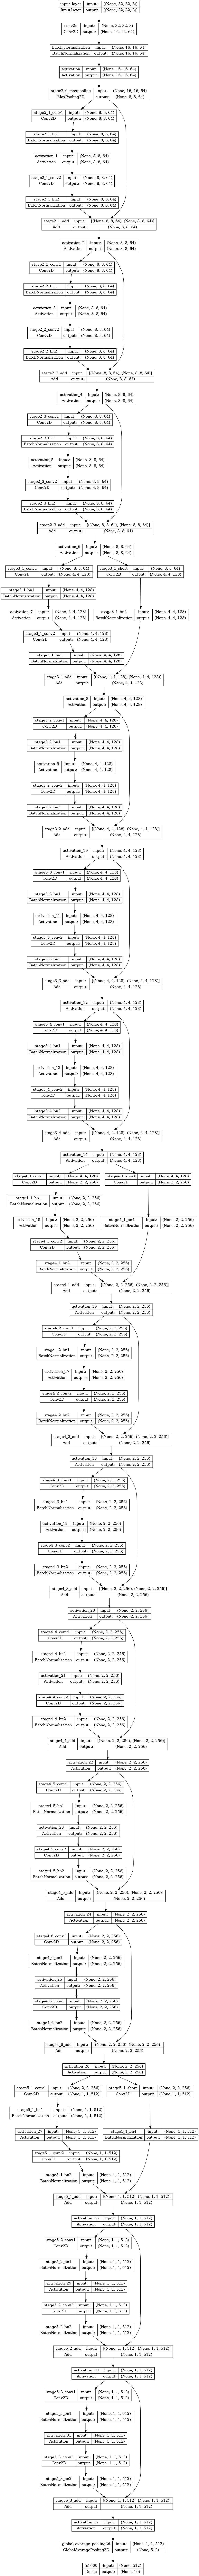

In [30]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()
tf.keras.utils.plot_model(resnet_34, show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['input_layer[0][0]']            
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                                  
 conv1_relu (Activation)        (None, 16, 16, 64)   0           ['conv1_bn[0][0]']               
                                                                                            

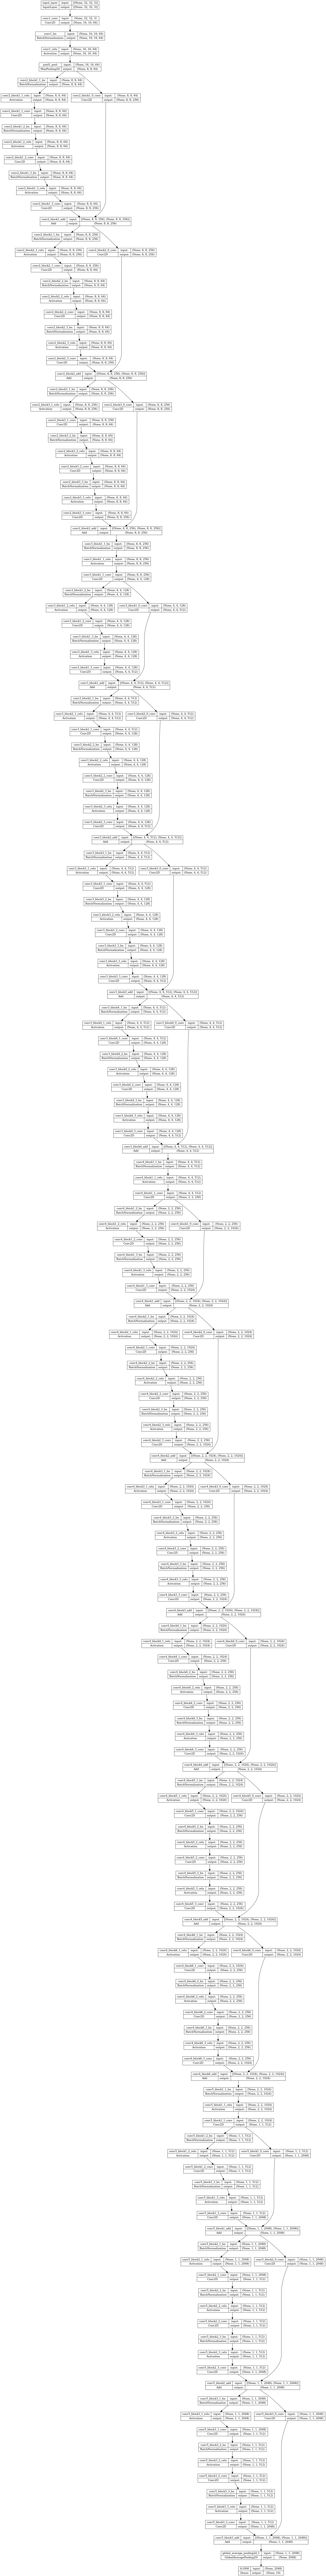

In [31]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()
tf.keras.utils.plot_model(resnet_50, show_shapes=True)

## 일반 네트워크(plain network) 만들기

### Plainnet-34

In [32]:
def build_plainnet_34_block_1(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1,
                       ):
    # 입력 레이어
    x = input_layer
    isInit = 1
    
    # CNN 레이어 num_cnn만큼 반복
    # filter는 위 채널
    for cnn_num in range(num_cnn):
        
        # 처음 실행될때만 실행 한다. stage2_0_maxpooling
        # 3x3 max pool, stride 2
        if isInit == 1:
            x = keras.layers.MaxPooling2D(pool_size=(3, 3),
                                            strides = 2,
                                            padding = 'same',
                                            name = f'stage{block_num}_{cnn_num}_maxpooling'
                                            )(x)
            
        # 첫번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{block_num}_{cnn_num + 1}_conv1'
        )(x)
        
        # 첫번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'stage{block_num}_{cnn_num + 1}_bn1'
            )(x)
        
        # 첫번째 Activation 적용
        x = keras.layers.Activation('relu')(x)
        
        # 두번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{block_num}_{cnn_num + 1}_conv2'
        )(x)
        
        # 두번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'stage{block_num}_{cnn_num + 1}_bn2'
            )(x)
        
        # 두번째 Activation 적용
        x = keras.layers.Activation('relu')(x)
        
        # 실행되었으므로 isInit 값을 바꿔줌
        isInit = 0
        
    return x

In [33]:
def build_plainnet_34_block_2(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1,
                       ):
    # 입력 레이어
    x = input_layer
    isInit = 1
    
    # CNN 레이어 num_cnn만큼 반복
    # filter는 위 채널
    for cnn_num in range(num_cnn):
        
        # 처음 실행될때만 실행 한다
        # size를 2배 낮추는 layer - padding 방법을 변경하였다.
        if isInit == 1:
            x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            strides = 2,
            padding='same',
            name=f'stage{block_num}_{cnn_num + 1}_conv1'
            )(x)
        
        # 처음 실행이 아닐 때 통상 Conv2D
        else:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(3,3),
                # activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num}_{cnn_num + 1}_conv1'
            )(x)
        
        # 첫번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'stage{block_num}_{cnn_num + 1}_bn1'
            )(x)
        
        # 첫번째 Activation 적용
        x = keras.layers.Activation('relu')(x)
        
        # 두번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{block_num}_{cnn_num + 1}_conv2'
        )(x)
        
        # 두번째 BatchNormalization 
        x = keras.layers.BatchNormalization(
            name = f'stage{block_num}_{cnn_num + 1}_bn2'
            )(x)
        
        # 두번째 Activation 적용
        x = keras.layers.Activation('relu')(x)
        
        # 실행되었으므로 isInit 값을 바꿔줌
        isInit = 0
        
    return x

### Plainnet-50

In [34]:
def build_plainnet_50_block_1(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1,
                       ):
    # 입력 레이어
    x = input_layer
    
    isInit = 1
    
    # CNN 레이어 num_cnn만큼 반복
    # filter는 위 채널
    # ResNet-50 : BN-ReLU-Conv-BN-ReLU-Conv-Add
    for cnn_num in range(num_cnn):
        
        # 처음 실행될때만 실행 한다. pool1_pool
        # 3x3 max pool, stride 2
        # 처음에만 Add로 들어갑니다.
        if isInit == 1:
            x = keras.layers.MaxPooling2D(pool_size=(3, 3),
                                          strides = 2,
                                          padding = 'same',
                                          name = f'pool{block_num-1}_pool'
                                          )(x)
        
        # 첫번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_1_bn'
            )(x)
        
        # 첫번째 Activation 적용
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_1_relu',
                                    )(x)
        
        # 첫번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(1,1),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_1_conv'
        )(x)
        
        # 두번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_2_bn'
            )(x)
        
        # 두번째 Activation 적용
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_2_relu',
                                    )(x)
        
        # 두번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_2_conv'
        )(x)
        
        # 채널 4배 증가가 추가되는 코드 (BN -> ReLU -> Conv -> Add)
        
        # BN x 
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_3_bn'
            )(x)
        
        # ReLU x
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_3_relu',
                                    )(x)
        
        # Conv
        # 기존의 값 channel 4배 증가
        x = keras.layers.Conv2D(
            # channel 4배 증가
            filters = 4 * channel,
            kernel_size=(1,1),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_3_conv'
        )(x)
        
        
        isInit = 0
        
    return x

In [35]:
def build_plainnet_50_block_2(input_layer,
                       num_cnn=3, 
                       channel=64,
                       block_num=1,
                       ):
    # 입력 레이어
    x = input_layer
    
    isInit = 1
    
    # CNN 레이어 num_cnn만큼 반복
    # filter는 위 채널
    # ResNet-50 : BN-ReLU-Conv-BN-ReLU-Conv-Add
    for cnn_num in range(num_cnn):
        
        # 첫번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_1_bn'
            )(x)
        
        # 첫번째 Activation 적용
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_1_relu',
                                    )(x)
        
        # 첫번째 CNN
        
        # 처음 실행될때만 실행 한다. 
        # 1x1, stride 2
        if isInit == 1:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                # activation='relu',
                kernel_initializer='he_normal',
                strides = 2,
                padding='same',
                name=f'conv{block_num}_block{cnn_num + 1}_1_conv'
                )(x)
            
        # 처음 실행이 아닐 때
        # 1x1, stride 1
        else:
            x = keras.layers.Conv2D(
                filters = channel,
                kernel_size=(1,1),
                # activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'conv{block_num}_block{cnn_num + 1}_1_conv'
                )(x)
        
        # 두번째 BatchNormalization
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_2_bn'
            )(x)
        
        # 두번째 Activation 적용
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_2_relu',
                                    )(x)
        
        # 두번째 CNN
        x = keras.layers.Conv2D(
            filters = channel,
            kernel_size=(3,3),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_2_conv'
        )(x)
        
        # 채널 4배 증가가 추가되는 코드 (BN -> ReLU -> Conv -> Add)
        
        # BN x 
        x = keras.layers.BatchNormalization(
            name = f'conv{block_num}_block{cnn_num + 1}_3_bn'
            )(x)
        
        # ReLU x
        x = keras.layers.Activation('relu',
                                    name=f'conv{block_num}_block{cnn_num + 1}_3_relu',
                                    )(x)
        
        # Conv
        # 기존의 값 channel 4배 증가
        x = keras.layers.Conv2D(
            # channel 4배 증가
            filters = 4 * channel,
            kernel_size=(1,1),
            # activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv{block_num}_block{cnn_num + 1}_3_conv'
        )(x)
        
        isInit = 0
        
    return x

### Build_plainnet()

In [36]:
def build_plainnet(input_shape=(32,32,3),
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   #  num_cnn_list=[3,4],
                   # #  channel_list=[64,128],
                   num_classes=10,
                   is_50 = False
                   ):
    
    # 블록마다 cnn과 channel을 설정해주기 때문에
    # num_cnn_list의 내부 원소 개수와 channel_list의 내부 원소 개수가 동일해야 합니다.
    assert len(num_cnn_list) == len(channel_list)
    
    # input layer를 만들어둡니다.
    input_layer = keras.layers.Input(shape=input_shape, name = 'input_layer')
    output = input_layer
    
    # ResNet-34 구현 시작
    if is_50 == False:
        # 첫번째 Conv2D 입니다, (None, 16, 16, 64)로 만듭니다.
        # 7x7, 64, stride 2
        output = keras.layers.Conv2D(filters=64,
                                    kernel_size=(7,7),
                                    # activation='relu',
                                    kernel_initializer='he_normal',
                                    padding='same',
                                    strides = 2,
                                    )(output)
        
        # BatchNormalization, Activation 을 적용합니다.
        output = keras.layers.BatchNormalization()(output)
        output = keras.layers.Activation('relu')(output)
        
        # config list들의 길이만큼 반복해서 블록을 생성합니다.
        # block 숫자 시작이 2이므로 i = 0 에서 시작을 i + 2로 만들어줌
        is_init_block = 1
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            
            # 첫번째 블록일때 만 1번 함수를 실행
            if is_init_block == 1:
                output = build_plainnet_34_block_1(
                    output, 
                    num_cnn = num_cnn, 
                    channel = channel, 
                    block_num = i + 2
                )
                # 블록 생성함.
                is_init_block = 0
            else:
                output = build_plainnet_34_block_2(
                    output,
                    num_cnn = num_cnn, 
                    channel = channel, 
                    block_num = i + 2
                )
        # Global Average Pooling 2D 논문에서 사용됐다고 나옴
        output = keras.layers.GlobalAveragePooling2D()(output)
        # Dense layer에 넣어주기 위해 flatten 합니다.
        # output = keras.layers.Flatten()(output)
        # 10개의 label 값에 대한 확률을 나타내기 위해 softmax 활성화 함수를 적용합니다.
        output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
        
    # ResNet-34 구현 완료
    
    # ResNet-50 구현 시작
    elif is_50 == True:
        
        # 첫번째 Conv2D 입니다, (None, 16, 16, 64)로 만듭니다.
        # 7x7, 64, stride 2
        output = keras.layers.Conv2D(filters=64,
                                    kernel_size=(7,7),
                                    # activation='relu',
                                    kernel_initializer='he_normal',
                                    padding='same',
                                    strides = 2,
                                    name = 'conv1_conv',
                                    )(output)
        
        # BatchNormalization, Activation 을 적용합니다.
        output = keras.layers.BatchNormalization(name = 'conv1_bn'
                                                )(output)
        output = keras.layers.Activation('relu',
                                         name = 'conv1_relu'
                                         )(output)
        
        is_init_block = 1
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            
            # 첫번째 블록일때 만 1번 함수를 실행
            if is_init_block == 1:
                output = build_plainnet_50_block_1(
                    output,
                    num_cnn = num_cnn, 
                    channel = channel,
                    block_num = i + 2
                )
                # 블록 생성함.
                is_init_block = 0
            else:
                output = build_plainnet_50_block_2(
                    output,
                    num_cnn = num_cnn, 
                    channel = channel,
                    block_num = i + 2
                )
        # Global Average Pooling 2D 논문에서 사용됐다고 나옴
        output = keras.layers.GlobalAveragePooling2D()(output)
        # Dense layer에 넣어주기 위해 flatten 합니다.
        # output = keras.layers.Flatten()(output)
        # 10개의 label 값에 대한 확률을 나타내기 위해 softmax 활성화 함수를 적용합니다.
        output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
        
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    
    return model

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_33 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 stage2_0_maxpooling (MaxPoo  (None, 8, 8, 64)         0         
 ling2D)                                                         
                                                                 
 stage2_1_conv1 (Conv2D)     (None, 8, 8, 64)          3692

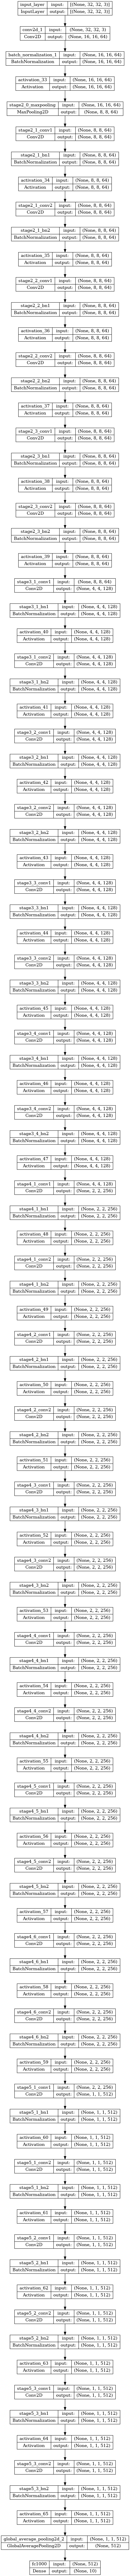

In [37]:
plainnet_34 = build_plainnet(input_shape=(32, 32, 3), is_50=False)
plainnet_34.summary()
tf.keras.utils.plot_model(plainnet_34, show_shapes=True)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        9472      
                                                                 
 batch_normalization_2 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_66 (Activation)  (None, 16, 16, 64)        0         
                                                                 
 stage2_0_maxpooling (MaxPoo  (None, 8, 8, 64)         0         
 ling2D)                                                         
                                                                 
 stage2_1_conv1 (Conv2D)     (None, 8, 8, 64)          3692

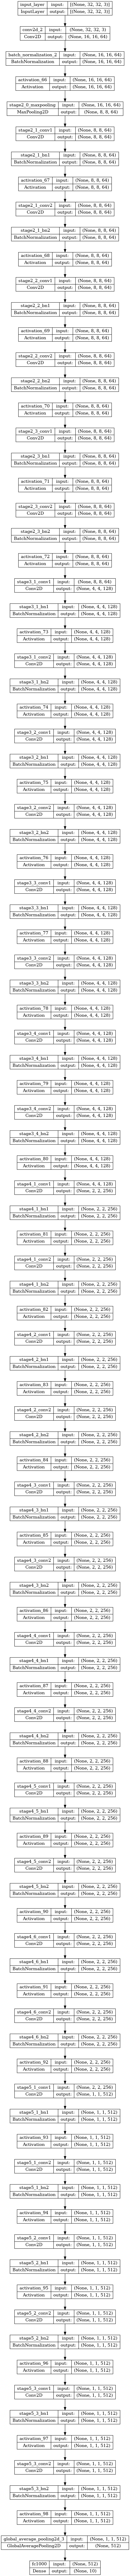

In [38]:
plainnet_50 = build_plainnet(input_shape=(32, 32, 3), is_50=False)
plainnet_50.summary()
tf.keras.utils.plot_model(plainnet_50, show_shapes=True)

## ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

### 학습 진행

In [39]:
# EPOCH = 30
EPOCH = 15

In [40]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [41]:
from gc import callbacks


resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # callbacks = callback,
    use_multiprocessing=True,
)

Epoch 1/15


2022-10-17 17:09:17.807607: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


195/195 [==============================] - 23s 65ms/step - loss: 2.3293 - accuracy: 0.2486 - val_loss: 2.0839 - val_accuracy: 0.2330
Epoch 2/15
195/195 [==============================] - 12s 62ms/step - loss: 1.6877 - accuracy: 0.4087 - val_loss: 1.8196 - val_accuracy: 0.3430
Epoch 3/15
195/195 [==============================] - 12s 60ms/step - loss: 1.4136 - accuracy: 0.5026 - val_loss: 1.7980 - val_accuracy: 0.3756
Epoch 4/15
195/195 [==============================] - 12s 60ms/step - loss: 1.1282 - accuracy: 0.6181 - val_loss: 1.8446 - val_accuracy: 0.3835
Epoch 5/15
195/195 [==============================] - 12s 60ms/step - loss: 0.8948 - accuracy: 0.7088 - val_loss: 1.8403 - val_accuracy: 0.4040
Epoch 6/15
195/195 [==============================] - 12s 60ms/step - loss: 0.6720 - accuracy: 0.7916 - val_loss: 1.9939 - val_accuracy: 0.3914
Epoch 7/15
195/195 [==============================] - 12s 60ms/step - loss: 0.4550 - accuracy: 0.8743 - val_loss: 2.0979 - val_accuracy: 0.4020
Epo

In [42]:
plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # callbacks = callback,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 18s 61ms/step - loss: 2.4314 - accuracy: 0.1139 - val_loss: 2.3224 - val_accuracy: 0.0979
Epoch 2/15
195/195 [==============================] - 11s 58ms/step - loss: 2.3246 - accuracy: 0.1262 - val_loss: 2.2987 - val_accuracy: 0.1251
Epoch 3/15
195/195 [==============================] - 11s 59ms/step - loss: 2.2353 - accuracy: 0.1629 - val_loss: 2.2435 - val_accuracy: 0.1799
Epoch 4/15
195/195 [==============================] - 11s 58ms/step - loss: 2.1117 - accuracy: 0.2011 - val_loss: 2.1878 - val_accuracy: 0.2044
Epoch 5/15
195/195 [==============================] - 11s 59ms/step - loss: 1.9909 - accuracy: 0.2443 - val_loss: 2.0278 - val_accuracy: 0.2422
Epoch 6/15
195/195 [==============================] - 11s 58ms/step - loss: 1.8908 - accuracy: 0.2818 - val_loss: 1.9495 - val_accuracy: 0.2775
Epoch 7/15
195/195 [==============================] - 11s 59ms/step - loss: 1.7997 - accuracy: 0.3234 - val_loss: 1.8574 - val_accuracy:

In [43]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # callbacks = callback,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 30s 105ms/step - loss: 3.3747 - accuracy: 0.2601 - val_loss: 2.5642 - val_accuracy: 0.2248
Epoch 2/15
195/195 [==============================] - 19s 99ms/step - loss: 2.1200 - accuracy: 0.3809 - val_loss: 2.3343 - val_accuracy: 0.3102
Epoch 3/15
195/195 [==============================] - 19s 97ms/step - loss: 1.6341 - accuracy: 0.4771 - val_loss: 2.3639 - val_accuracy: 0.3375
Epoch 4/15
195/195 [==============================] - 19s 98ms/step - loss: 1.2486 - accuracy: 0.5814 - val_loss: 2.3192 - val_accuracy: 0.3529
Epoch 5/15
195/195 [==============================] - 19s 97ms/step - loss: 0.9077 - accuracy: 0.6939 - val_loss: 2.2628 - val_accuracy: 0.3675
Epoch 6/15
195/195 [==============================] - 19s 97ms/step - loss: 0.6785 - accuracy: 0.7762 - val_loss: 2.3711 - val_accuracy: 0.3632
Epoch 7/15
195/195 [==============================] - 19s 97ms/step - loss: 0.4671 - accuracy: 0.8554 - val_loss: 2.5273 - val_accuracy

In [44]:
plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # callbacks = callback,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 16s 60ms/step - loss: 2.4269 - accuracy: 0.1153 - val_loss: 2.3241 - val_accuracy: 0.0974
Epoch 2/15
195/195 [==============================] - 11s 57ms/step - loss: 2.3283 - accuracy: 0.1271 - val_loss: 2.3262 - val_accuracy: 0.1180
Epoch 3/15
195/195 [==============================] - 11s 57ms/step - loss: 2.2578 - accuracy: 0.1487 - val_loss: 2.3697 - val_accuracy: 0.1658
Epoch 4/15
195/195 [==============================] - 11s 57ms/step - loss: 2.1682 - accuracy: 0.1785 - val_loss: 2.1828 - val_accuracy: 0.1867
Epoch 5/15
195/195 [==============================] - 11s 58ms/step - loss: 2.0579 - accuracy: 0.2110 - val_loss: 2.0830 - val_accuracy: 0.2225
Epoch 6/15
195/195 [==============================] - 11s 57ms/step - loss: 1.9250 - accuracy: 0.2631 - val_loss: 1.9987 - val_accuracy: 0.2609
Epoch 7/15
195/195 [==============================] - 11s 57ms/step - loss: 1.8169 - accuracy: 0.3141 - val_loss: 1.9184 - val_accuracy:

### 그래프

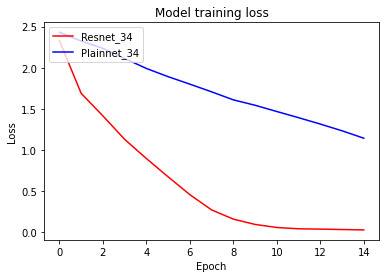

In [45]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet_34', 'Plainnet_34'], loc='upper left')
plt.show()

* ResNet-34는 처음엔 plain이 더 낮은 loss를 가지고 있다가 Epoch가 증가함에 따라 ResNet의 loss 값이 더 낮아집니다.

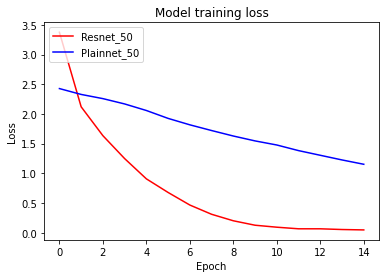

In [46]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Resnet_50', 'Plainnet_50'], loc='upper left')
plt.show()

* ResNet-50은 Resnet이 더 가파르게 loss가 감소합니다, 아마 epoch 수를 증가시키면 Resnet의 loss가 더 떨어질 것 같습니다.

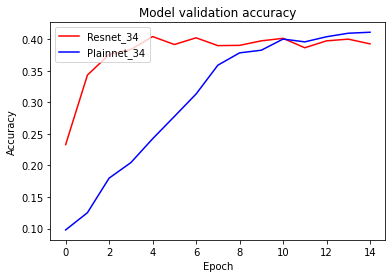

In [47]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet_34', 'Plainnet_34'], loc='upper left')
plt.show()

* Validation accuracy는 Resnet-34이 Plainnet-34이 더 높게 나옵니다.

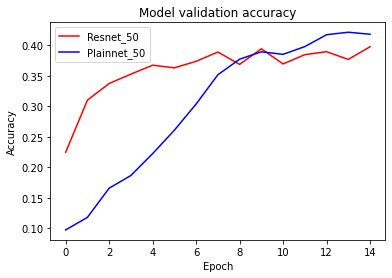

In [48]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Resnet_50', 'Plainnet_50'], loc='upper left')
plt.show()

* Resnet-50은 처음엔 plain이 더 높다가 결국 Resnet이 더 높게 나옵니다.

### 회고

* 이번 프로젝트에서 어려웠던 점
    - Resnet-50의 bottleneck 구조를 구현하는게 어려웠습니다.
    - BN와 Activation의 순서를 바꿔서 구현하는게 어려웠습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된점
    - BN과 Activation, Conv layer들의 위치에 따라 모델의 성능이 바뀝니다. 
  * 아직 모호한 점
    - Resnet-50의 loss가 낮은 epoch에서 plain보다 더 높게 나와서 더 높은 epoch로 실험해볼 필요가 있습니다.
    - 크기가 큰 데이터 사용시 local에서 자꾸 렉이 걸려서 다르게 사용할 방법을 찾아보겠습니다.
* 루브릭 평가를 맞추기 위해 시도한 점
    - model의 쉽게 볼 수 있게 블록을 그렸습니다.
    - resnet_34, resnet_50에 따른 그래프를 그렸습니다.